In [1]:
!git clone https://github.com/google/deluca.git

Cloning into 'deluca'...
remote: Enumerating objects: 3658, done.
remote: Counting objects: 100% (855/855), done.
remote: Compressing objects: 100% (515/515), done.
remote: Total 3658 (delta 491), reused 575 (delta 325), pack-reused 2803 (from 2)
Receiving objects: 100% (3658/3658), 28.97 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (2041/2041), done.


In [2]:
%cd deluca

!pip install -e .

/content/deluca
Obtaining file:///content/deluca
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.7/341.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.8/708.8 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 16.0 MB/s eta 0:00:00
  Running setup.py develop for deluca


In [3]:
%load_ext autoreload
%autoreload 2

# Imports
# Standard library imports
from typing import Sequence

# Third-party imports
import jax
import jax.numpy as jnp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from brax.envs.inverted_double_pendulum import InvertedDoublePendulum

# Local imports
from deluca.agents._drc import DRC
from deluca.agents._grc import GRC
from deluca.agents._lqg import LQG
from deluca.agents._random import SimpleRandom
from deluca.agents._sfc import SFC
from deluca.agents._zero import Zero
from deluca.core import Agent, Env, field
from deluca.envs import LDS, SinusDisturbance, Pendulum2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
trajectory length = 1000


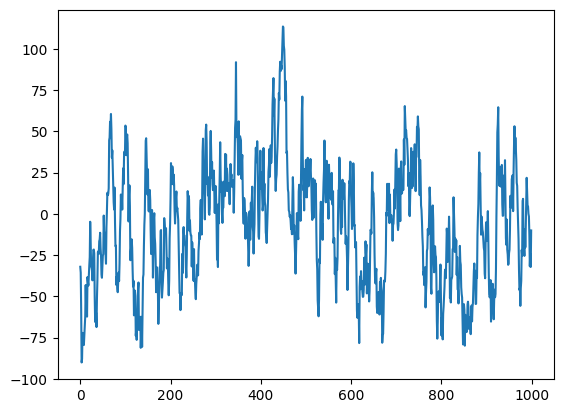

In [4]:
%load_ext autoreload
%autoreload 2

env = LDS() #LDS with random initiations and dimensions as specified
#env = lds.LDS(2,10,3) #LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)
env.show_me_the_signal(1000)

In [79]:
""" Specrtal learning implementation. """
from functools import partial
from typing import Callable

import scipy
import jax
import jax.numpy as jnp
from jax import jit
from jax.scipy.linalg import eigh

def compute_filter_matrix(T: int, h: int = 24) -> jnp.ndarray:
    """Compute the spectral filter matrix.

    Args:
        T: Context length
        h: Number of eigenvectors to use

    Returns:
        Filter matrix of shape (h * T)
    """
    matrix = scipy.linalg.hilbert(T)
    # Compute eigenvalues and eigenvectors
    matrix = np.float64(matrix)
    eigenvalues, eigenvectors = scipy.linalg.eigh(matrix)

    # Sort in descending order and take top h
    idx = jnp.argsort(eigenvalues)[::-1][:h]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]


    filter_matrix = eigenvectors * (np.abs(eigenvalues) ** 0.25)[None, :]
    return filter_matrix



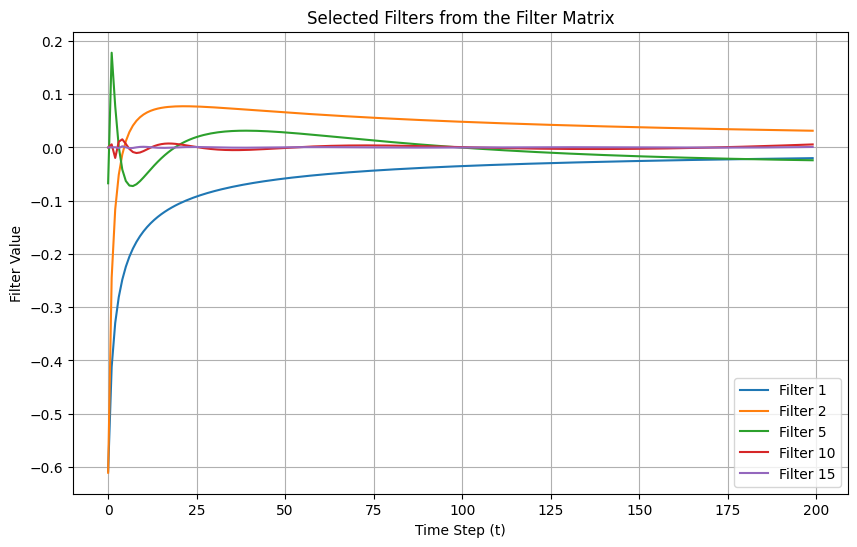

In [81]:
def evan_get_filters(L: int, k: int = 24):
  k = min(k, L)
  i = np.arange(1, L + 1)
  i_plus_j = i[None] + i[:, None]
  Z = 2 / (i_plus_j ** 3 - i_plus_j)
  Z = np.float64(Z)
  evals, evecs = scipy.linalg.eigh(Z)
  return evecs[::-1, -k:] # * (evals[-k:] ** 0.25)


# Assume filter_matrix is the output of compute_filter_matrix(T)
T = 200  # Example T value
filter_matrix = compute_filter_matrix(T)
#filter_matrix = get_filters(T)
filters_to_plot = [1, 2, 5, 10, 15]  # Column indices (1-based)

plt.figure(figsize=(10, 6))
for col_index in filters_to_plot:
    # Column indices are 0-based in Python, so subtract 1
    plt.plot(filter_matrix[:, col_index - 1], label=f'Filter {col_index}')

plt.title('Selected Filters from the Filter Matrix')
plt.xlabel('Time Step (t)')
plt.ylabel('Filter Value')
plt.legend()
plt.grid(True)
plt.show()
